---

# Objective 

Forest fires help in the natural cycle of woods' growth and replenishment. They Clear dead trees, leaves, and competing vegetation from the forest floor, so new plants can grow. Remove weak or disease-ridden trees, leaving more space and nutrients for stronger trees.


But when fires burn too hot and uncontrollable or when they’re in the “wildland-urban interface” (the places where woodlands and homes or other developed areas meet), they can be damaging and life threatning.


In this kernel, our aim is to predict the burned area (`area`) of forest fires, in the northeast region of Portugal. Based on the the spatial, temporal, and weather variables where the fire is spotted. 

This prediction can be used for calculating the forces sent to the incident and deciding the urgency of the situation.


In [11]:
target = 'area'

---

# Define the metrics

**RMSE** 

RMSE is the most popular evaluation metric used in regression problems. It follows an assumption that error are unbiased and follow a normal distribution.


---

# Dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from scipy.stats import zscore
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split,KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV,ElasticNetCV

---

In [3]:
import os

os.chdir("E:\\forest_fires")

# Load and describe data

In [4]:
# path = 'forestfires.csv'
path = "forestfires.csv"
df = pd.read_csv(path)

df.shape

(517, 13)

In [5]:
df.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


---

# Missing value treatment

In [7]:
df.isna().sum().sum()

0

---

# Exploratory Data Analysis
   We will try out the following analysis on our dataset
   - Univariate 
   - Bivariate 
   - Multivariate

In [8]:
plt.rcParams["figure.figsize"] = 9,5

---

## Univariate analysis



### Let's begin with the target variable, `Area`

Skew: 12.846933533934868
Kurtosis: 194.1407210942299


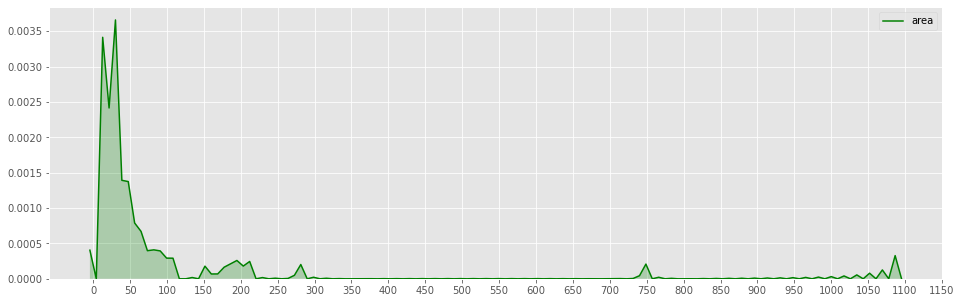

In [12]:
plt.figure(figsize=(16,5))
print("Skew: {}".format(df[target].skew()))
print("Kurtosis: {}".format(df[target].kurtosis()))
ax = sns.kdeplot(df[target],shade=True,color='g')
plt.xticks([i for i in range(0,1200,50)])
plt.show()

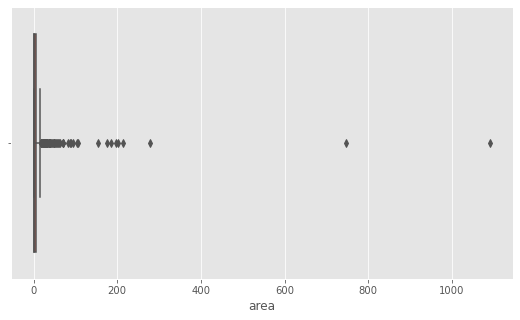

In [13]:
ax = sns.boxplot(df[target])

**Few observations:**

- The data is highly skewed with a value of +12.84 and huge kurtosis value of 194.

- It even tells you that majority of the forest fires do not cover a large area, most of the damaged area is under 50 hectares of land.

- We can apply tranformation to fix the skewnesss and kurtosis, however we will have to inverse transform before submitting the output.

- Outlier Check: There are 4 outlier instances in our area columns but the questions is should we drop it or not? (Will get back to this in the outlier treatment step)

In [14]:
# Outlier points
y_outliers = df[abs(zscore(df[target])) >= 3 ]
y_outliers

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
237,1,2,sep,tue,91.0,129.5,692.6,7.0,18.8,40,2.2,0.0,212.88
238,6,5,sep,sat,92.5,121.1,674.4,8.6,25.1,27,4.0,0.0,1090.84
415,8,6,aug,thu,94.8,222.4,698.6,13.9,27.5,27,4.9,0.0,746.28
479,7,4,jul,mon,89.2,103.9,431.6,6.4,22.6,57,4.9,0.0,278.53


### Independent columns 

In [15]:
dfa = df.drop(columns=target)
cat_columns = dfa.select_dtypes(include='object').columns.tolist()
num_columns = dfa.select_dtypes(exclude='object').columns.tolist()

cat_columns,num_columns

(['month', 'day'],
 ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain'])

### Categorical columns 

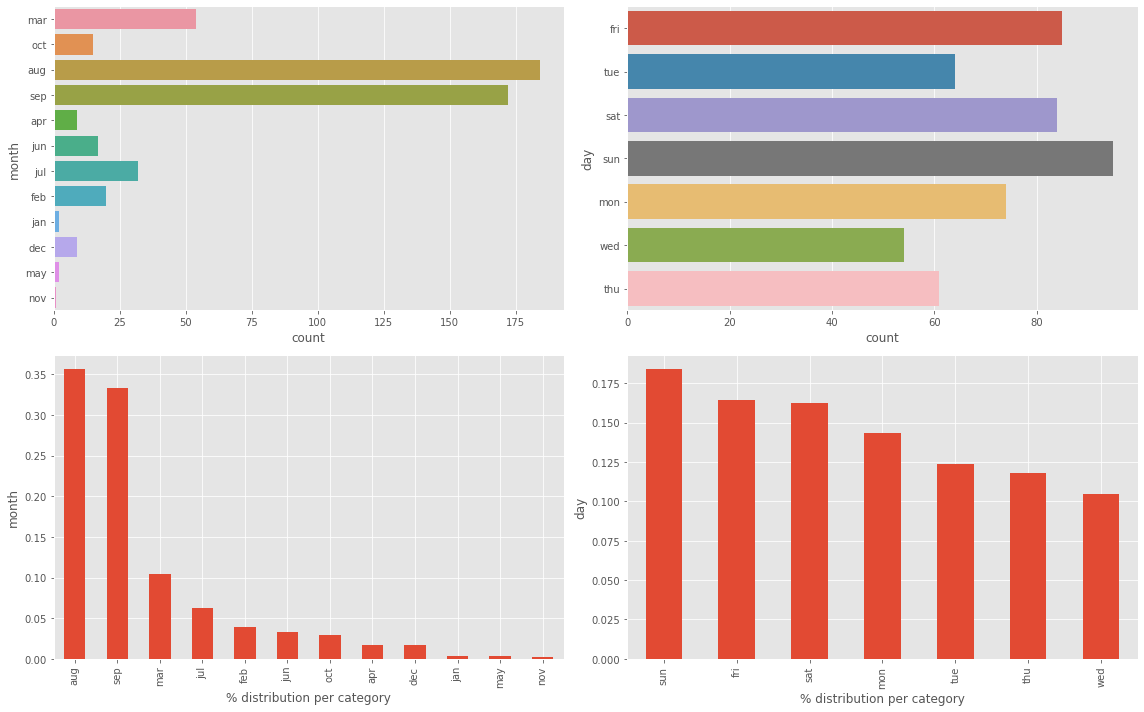

In [16]:
# analyzing categorical columns
plt.figure(figsize=(16,10))
for i,col in enumerate(cat_columns,1):
    plt.subplot(2,2,i)
    sns.countplot(data=dfa,y=col)
    plt.subplot(2,2,i+2)
    df[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()    

1. It is interesting to see that abnormally high number of the forest fires occur in the month of `August`
and `September`.

2. In the case of day, the days `Friday` to `Monday` have higher proportion of cases. (However, no strong indicators)

### Numerical Columns

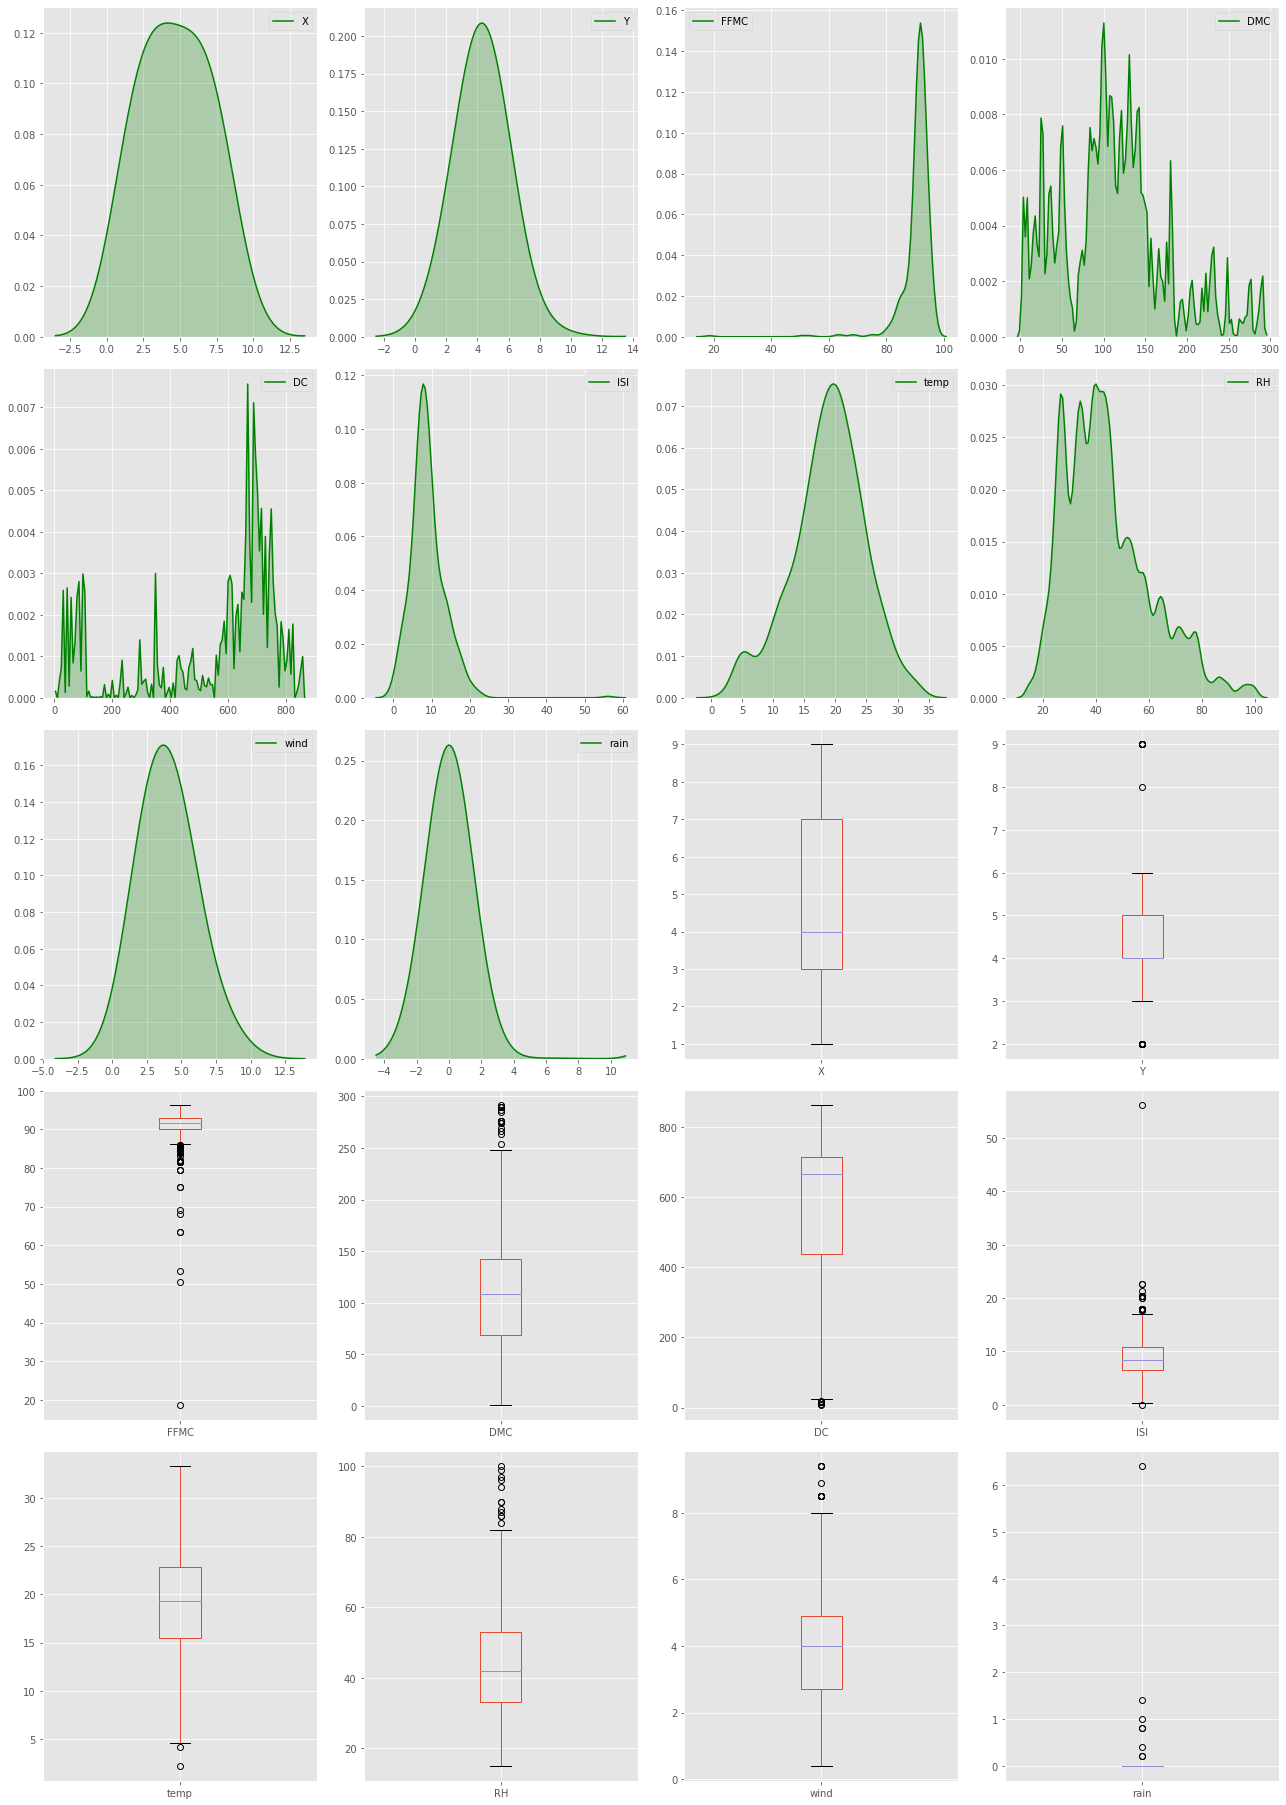

In [24]:
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col],color='g',shade=True, bw=1.5)
    plt.subplot(8,4,i+10)
    df[col].plot.box()
plt.tight_layout() 
plt.show()

In [25]:
num_data = df[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
skewness,0.036246,0.417296,-6.575606,0.547498,-1.100445,2.536325,-0.331172,0.862904,0.571001,19.816344
kurtosis,-1.172331,1.420553,67.066041,0.204822,-0.245244,21.458037,0.136166,0.438183,0.054324,421.295964


Outliers, Skewness and kurtosis (high positive or negative) was observed in the following columns:
1. FFMC
2. ISI
3. rain

---

## Bivariate analysis with our target variable

In [26]:
print(df['area'].describe(),'\n')
print(y_outliers)

count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64 

     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain     area
237  1  2   sep  tue  91.0  129.5  692.6   7.0  18.8  40   2.2   0.0   212.88
238  6  5   sep  sat  92.5  121.1  674.4   8.6  25.1  27   4.0   0.0  1090.84
415  8  6   aug  thu  94.8  222.4  698.6  13.9  27.5  27   4.9   0.0   746.28
479  7  4   jul  mon  89.2  103.9  431.6   6.4  22.6  57   4.9   0.0   278.53


In [27]:
# a categorical variable based on forest fire area damage
# No damage, low, moderate, high, very high
def area_cat(area):
    if area == 0.0:
        return "No damage"
    elif area <= 1:
        return "low"
    elif area <= 25:
        return "moderate"
    elif area <= 100:
        return "high"
    else:
        return "very high"

df['damage_category'] = df['area'].apply(area_cat)
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,damage_category
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,No damage
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,No damage
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,No damage
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,No damage
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,No damage


### Categorical columns

In [28]:
cat_columns

['month', 'day']

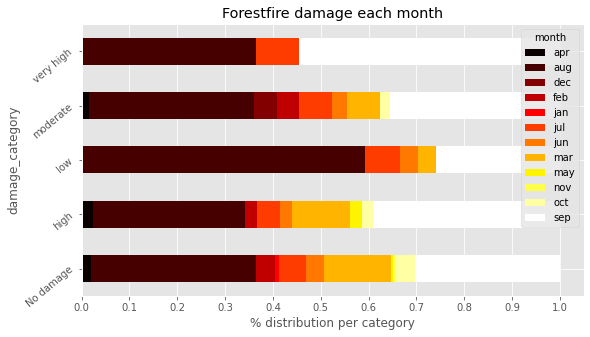

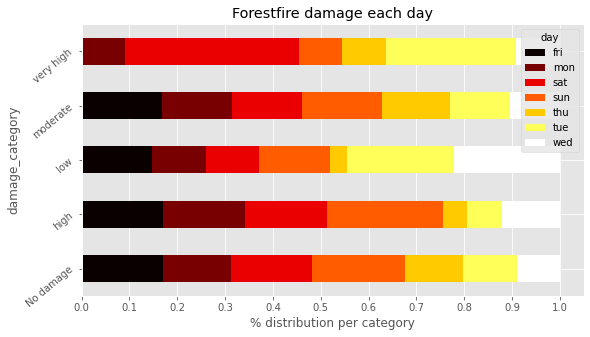

In [29]:
for col in cat_columns:
    cross = pd.crosstab(index=df['damage_category'],columns=df[col],normalize='index')
    cross.plot.barh(stacked=True,rot=40,cmap='hot')
    plt.xlabel('% distribution per category')
    plt.xticks(np.arange(0,1.1,0.1))
    plt.title("Forestfire damage each {}".format(col))
plt.show()

- Previously we had observed that `August` and `September` had the most number of forest fires. And from the above plot of `month`, we can understand few things
    - Most of the fires in August were low (< 1 hectare).
    - The very high damages(>100 hectares) happened in only 3 months - august,july and september.
 
- Regarding fire damage per day, nothing much can be observed. Except that, there were no ` very high` damaging fires on Friday and on Saturdays it has been reported most.

### Numerical columns

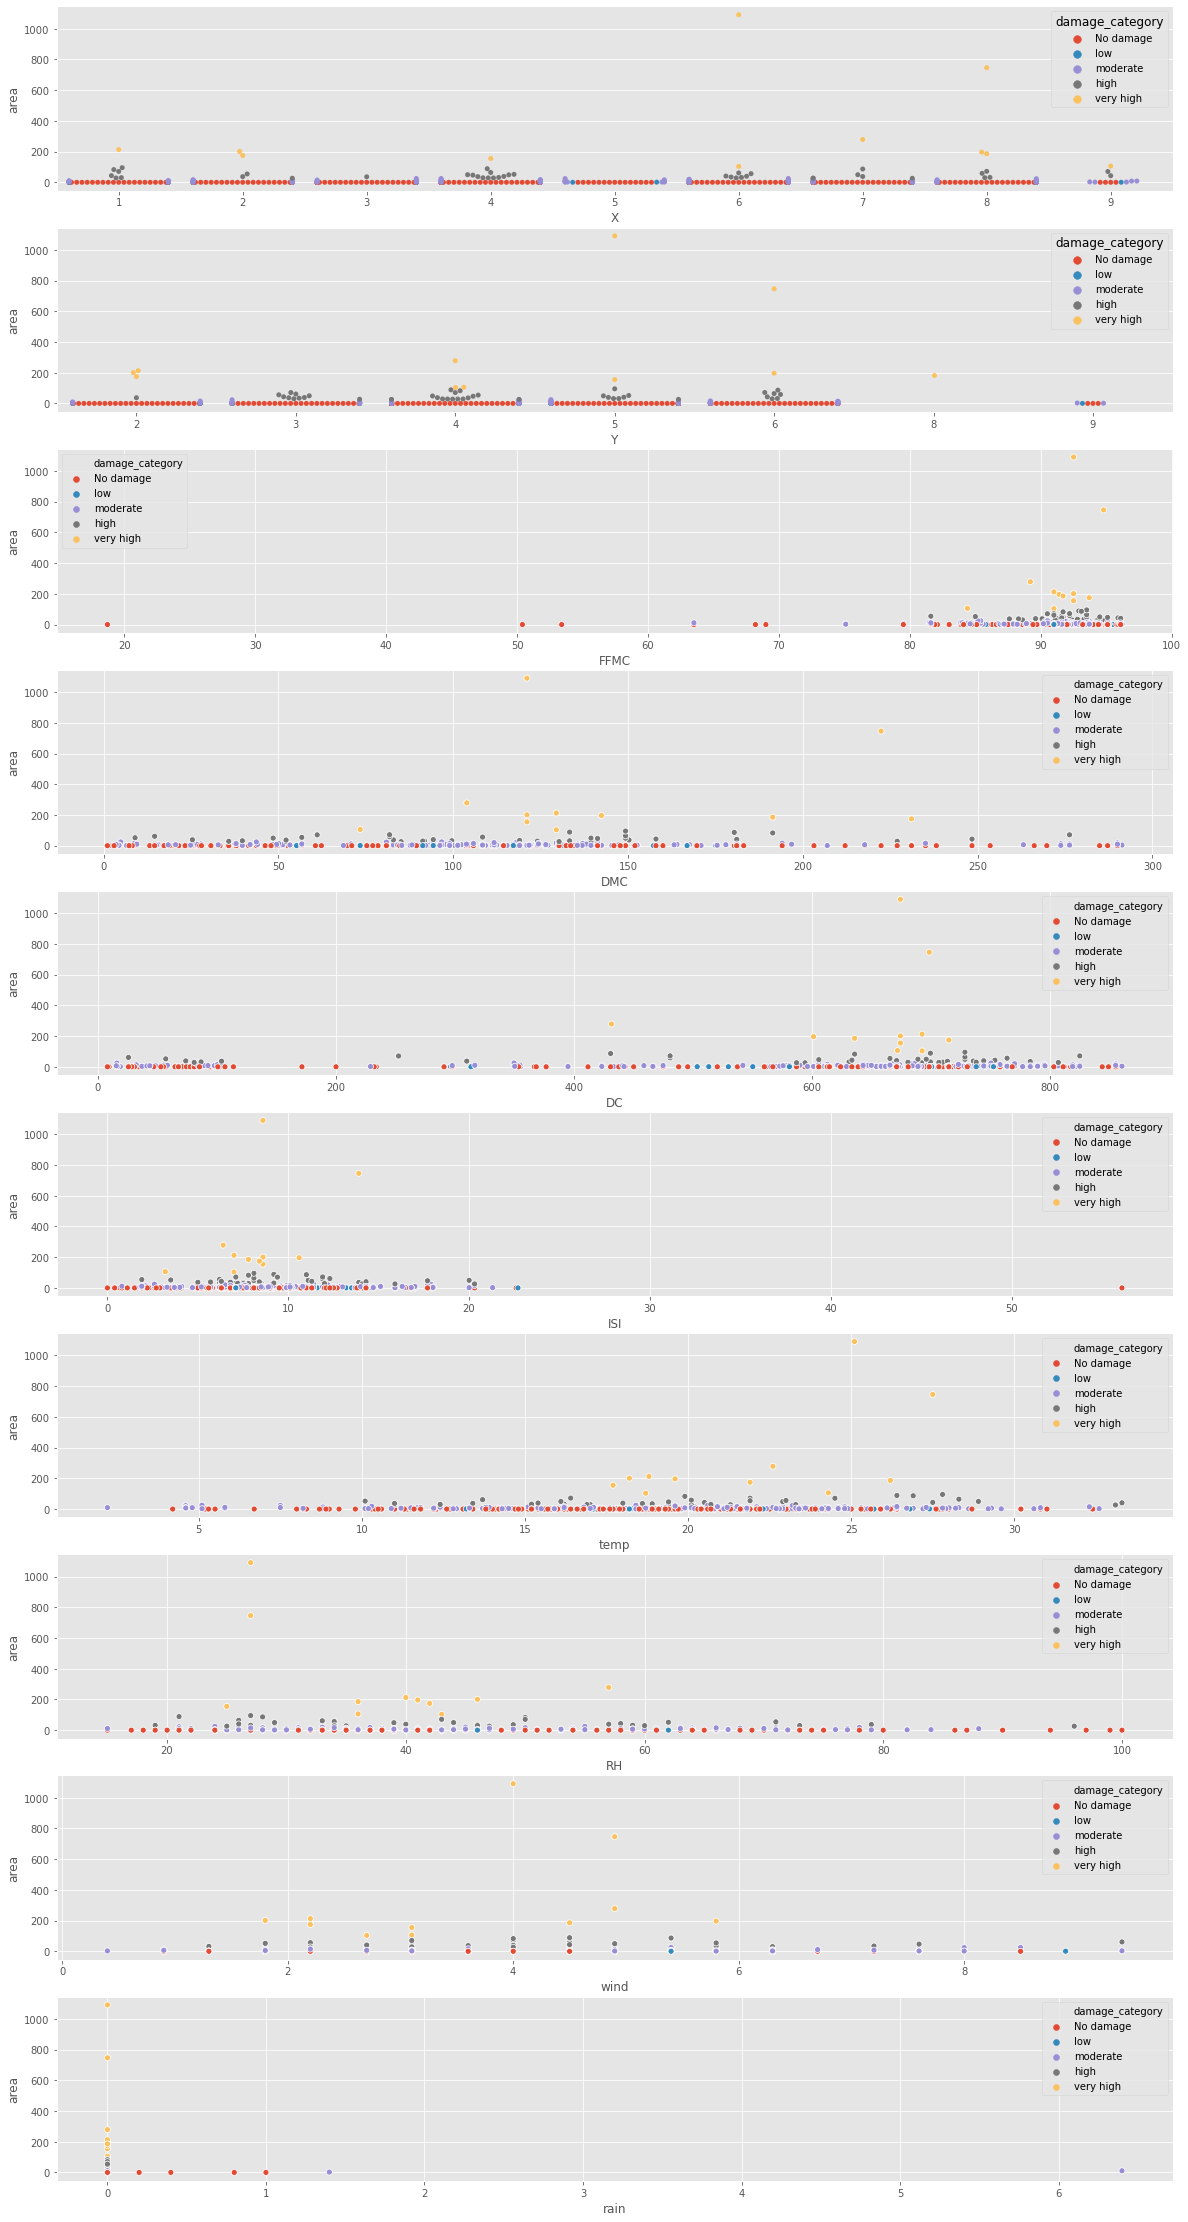

In [30]:
plt.figure(figsize=(20,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(10,1,i)
    if col in ['X','Y']:
        sns.swarmplot(data=df,x=col,y=target,hue='damage_category')
    else:
        sns.scatterplot(data=df,x=col,y=target,hue='damage_category')
plt.show()

---

## Multivariate analysis

In [31]:
selected_features = df.drop(columns=['damage_category','day','month']).columns
selected_features

Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'area'],
      dtype='object')

In [35]:
df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,damage_category
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,No damage
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,No damage
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,No damage
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,No damage
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,No damage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,moderate
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,high
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,moderate
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,No damage


---

# Outlier treatment

We had observed outliers in the following columns:
1. area 
2. FFMC
2. ISI
3. rain

In [36]:
out_columns = ['area','FFMC','ISI','rain']

---

# Preparing the data for modelling
Thing which we can cover here
- Encoding the categorical columns 

In [37]:
df = pd.get_dummies(df,columns=['day','month'],drop_first=True)

- Data transformations like `log,root,inverse,exponential`,etc

In [38]:
print(df[out_columns].describe())
np.log1p(df[out_columns]).skew(), np.log1p(df[out_columns]).kurtosis()

              area        FFMC         ISI        rain
count   517.000000  517.000000  517.000000  517.000000
mean     12.847292   90.644681    9.021663    0.021663
std      63.655818    5.520111    4.559477    0.295959
min       0.000000   18.700000    0.000000    0.000000
25%       0.000000   90.200000    6.500000    0.000000
50%       0.520000   91.600000    8.400000    0.000000
75%       6.570000   92.900000   10.800000    0.000000
max    1090.840000   96.200000   56.100000    6.400000


(area     1.217838
 FFMC   -11.675394
 ISI     -0.937218
 rain    14.173028
 dtype: float64,
 area      0.945668
 FFMC    185.482383
 ISI       2.584588
 rain    234.240025
 dtype: float64)

In [39]:
# FFMC and rain are still having high skew and kurtosis values, 
# since we will be using Linear regression model we cannot operate with such high values
# so for FFMC we can remove the outliers in them using z-score method
mask = df.loc[:,['FFMC']].apply(zscore).abs() < 3

# Since most of the values in rain are 0.0, we can convert it as a categorical column
df['rain'] = df['rain'].apply(lambda x: int(x > 0.0))

df = df[mask.values]
df.shape

(510, 29)

In [40]:
out_columns.remove('rain')
df[out_columns] = np.log1p(df[out_columns])

In [41]:
df[out_columns].skew()

area    1.208492
FFMC   -1.803993
ISI    -0.434372
dtype: float64

In [42]:
# we will use this dataframe for building our ML model
df_ml = df.drop(columns=['damage_category']).copy()

---

# Linear Regression

**In this kernel we will be working on Linear regression using both Statistical and Machine learning approach.**



**Difference between statistical and machine learning approach**

- Machine learning produces **predictions**.  As far as I can tell, it is not very good at drawing conclusions about general principles based on a set of observations.
- Statistical estimation lets the practitioner make **inferences** (conclusions about a larger set of phenomena based on the observation of a smaller set of phenomena.)  For example, in a regression model the practitioner can estimate the effect of a one unit change in an independent variable X on a dependent variable y.

Further read: [Quora](https://www.quora.com/When-do-you-use-machine-learning-vs-statistical-regression)

In [45]:
y = df['area']
X = df.drop(columns=['area','damage_category'])


---

# Statistical approach

## Checking assumptions for linear regression in statistics

1. Linearity of model
    
2. Normality of residuals

3. Homoscedasticity

4. No Autocorrelation

5. Multicollinearity 

In [47]:
X_constant = sm.add_constant(X)

# Build OLS model
lin_reg = sm.OLS(y,X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1.489
Date:                Fri, 31 Jul 2020   Prob (F-statistic):             0.0558
Time:                        17:16:42   Log-Likelihood:                -874.85
No. Observations:                 510   AIC:                             1806.
Df Residuals:                     482   BIC:                             1924.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3192     18.275      0.017      0.986     -35.590      36.228
X              0.0532      0.033      1.621      0.106      -0.011       0.118
Y             -0.0115      0.061     -0.187      0.852      -0.132       0.109
FFMC          -0.1061      4.160     -0.025      0.980      -8.280       8.068
DMC            0.0041      0.002      2.166      0.031       0.000       0.008
DC            -0.0019      0.001     -1.440      0.150      -0.004       0.001
ISI           -0.1039      0.290     -0.358      0.720      -0.674       0.466
temp           0.0443      0.023      1.964      0.050   -2.77e-05       0.089
RH             0.0041      0.007      0.624      0.533      -0.009       0.017
wind           0.0678      0.039      1.719      0.086      -0.010       0.145
rain          -0.9272      0.547     -1.695      0.091      -2.002       0.148
day_mon        0.1076      0.230      0.467      0.641      -0.345       0.560
day_sat        0.3312      0.222      1.493      0.136      -0.105       0.767
day_sun        0.1794      0.215      0.836      0.403      -0.242       0.601
day_thu        0.0714      0.243      0.294      0.769      -0.406       0.549
day_tue        0.3483      0.238      1.464      0.144      -0.119       0.816
day_wed        0.1960      0.248      0.791      0.429      -0.291       0.683
month_aug      0.2450      0.847      0.289      0.772      -1.419       1.909
month_dec      2.2223      0.804      2.764      0.006       0.643       3.802
month_feb      0.2217      0.568      0.391      0.696      -0.894       1.337
month_jan     -0.8605      1.483     -0.580      0.562      -3.775       2.054
month_jul      0.0319      0.731      0.044      0.965      -1.405       1.469
month_jun     -0.3316      0.679     -0.488      0.625      -1.666       1.002
month_mar     -0.2613      0.519     -0.503      0.615      -1.282       0.759
month_may      0.6256      1.106      0.565      0.572      -1.548       2.800
month_nov     -1.1779      1.490     -0.790      0.430      -4.106       1.750
month_oct      0.7718      1.005      0.768      0.443      -1.203       2.747
month_sep      0.8978      0.949      0.946      0.345      -0.967       2.762
==============================================================================
Omnibus:                       76.076   Durbin-Watson:                   0.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.018
Skew:                           1.074   Prob(JB):                     5.77e-24
Kurtosis:                       3.652   Cond. No.                     1.89e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+05. This might i

---

## 1. Linearity of residuals


**Linearity can be measured by two methods:**

- Plot the observed values Vs predicted values` and plot the `Residual Vs predicted values` and see the linearity of residuals. 
-  Rainbow test

**Rainbow test**

E:\work_table\conda\lib\site-packages\statsmodels\stats\outliers_influence.py:693: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


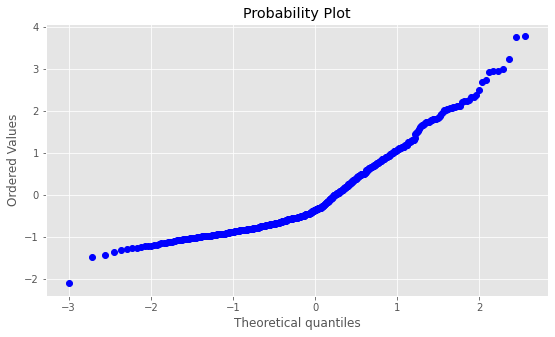

In [48]:
import scipy.stats as stats
import pylab

# get an instance of Influence with influence and outlier measures 
st_resid = lin_reg.get_influence().resid_studentized_internal
stats.probplot(st_resid,dist="norm",plot=pylab)
plt.show()

- **Null hypothesis (H0):** The Null hypothesis is that the regression is correctly modeled as linear.
- **Alternate hypothesis(H1)**: The model is non-linear

In [49]:
# return fstat and p-value
sm.stats.diagnostic.linear_rainbow(lin_reg)

(1.2832659161650848, 0.027048891500426765)

**Expectation Mean of residual is zero**

In [50]:
# The mean expected value around 0, it implies linearity is preserved
lin_reg.resid.mean()

1.5404235621279476e-14

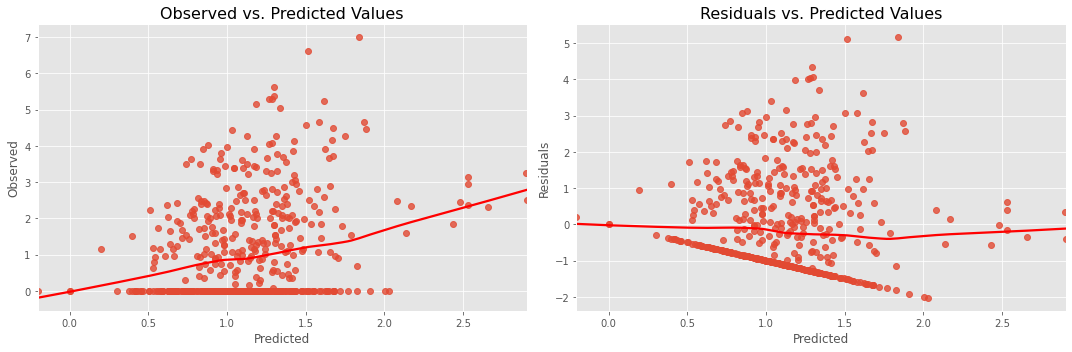

In [51]:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2,figsize=(15,5))

    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
linearity_test(lin_reg, y) 
plt.tight_layout()

The desired outcome of plots is that points are symmetrically distributed around a diagonal line in the former plot or around horizontal line in the latter one. 

> - By observing  the plots the linearity assumption is not there 
- Adding new features might result in linearity of model 
- Also, transforming the feature from non-linear to linear using various data transformation techniques can help.

---

## 2. Normality of the residuals

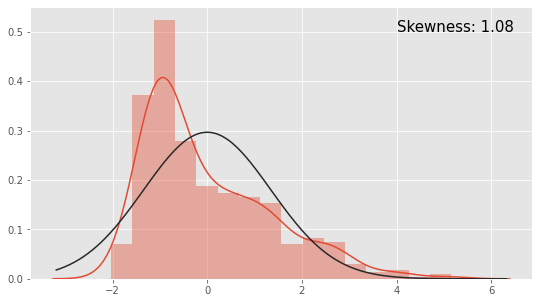

In [52]:
sns.distplot(lin_reg.resid,fit=stats.norm)
plt.text(4,0.5,f"Skewness: {round(lin_reg.resid.skew(),2)}",fontsize=15)
plt.show()

**Test for normality: Jarque Bera**

For a good model, the residuals should be normally distributed.
The higher the value of Jarque Bera test, the lesser the residuals are normally distributed.

The Jarque–Bera test is a goodness-of-fit test of whether sample data 
have the skewness and kurtosis matching a normal distribution.

> Jarque-Bera (JB):	107.018

The jarque bera test tests whether the sample data has the skewness and kurtosis matching a normal distribution.

Note that this test generally works good for large enough number of data samples(>2000) as the test statistics asymptotically has a chi squared distribution with degrees 2 of freedom.

> Our dataframe length, 517

**Null hypothesis (H0)** - Residuals are normally distributed

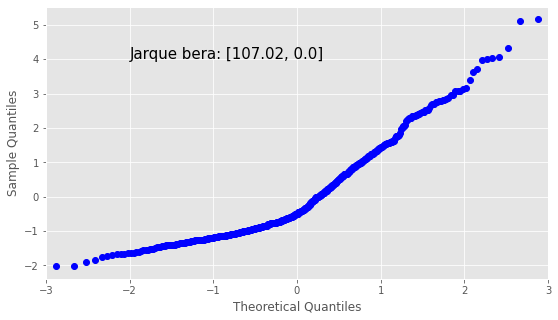

In [53]:
sm.qqplot(lin_reg.resid,line ='r')
jb = [round(n,2) for n in stats.jarque_bera(lin_reg.resid)]
plt.text(-2,4,f"Jarque bera: {jb}",fontsize=15)
plt.show()

> The p-value is 0 which simply means we can reject out NULL hypothesis.
We can fix that by
- Removing the outliers in the data
- Fixing the Non-linearity in our dependent or target feature
- Removing the bias, the bias might be contributing to the non-normality. 

---

## 3. Homoscedasticity





Homoscedacity: If the residuals are symmetrically distributed across the trend , then it is called as homoscedacious. 

Heteroscedacity: If the residuals are not symmetric across the trend, then it is called as heteroscedacious.


**Goldfeld-Quandt test for Homoscedasticity**

H0 = constant variance among residuals (Homoscedacity)

Ha = Heteroscedacity.

In [54]:
sms.het_goldfeldquandt(lin_reg.resid, lin_reg.model.exog)

(0.9005330268628144, 0.7860123901512466, 'increasing')

E:\work_table\conda\lib\site-packages\statsmodels\stats\outliers_influence.py:693: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


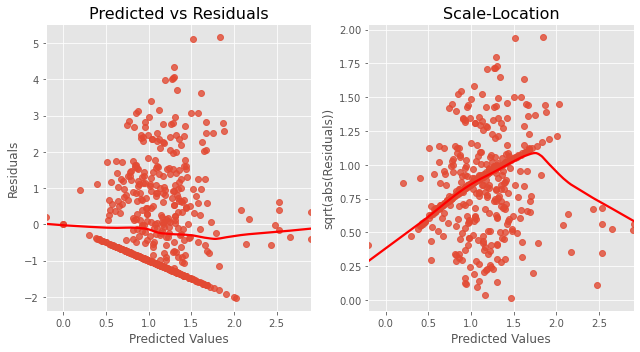

In [55]:
model = lin_reg
fitted_vals = model.predict()
resids = model.resid
resids_standardized = model.get_influence().resid_studentized_internal

fig, ax = plt.subplots(1,2)

sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Predicted vs Residuals', fontsize=16)
ax[0].set(xlabel='Predicted Values', ylabel='Residuals')

sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
ax[1].set_title('Scale-Location', fontsize=16)
ax[1].set(xlabel='Predicted Values', ylabel='sqrt(abs(Residuals))')

name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model.resid, model.model.exog)
lzip(name, test)
plt.tight_layout()

>- To identify homoscedasticity in the plots, the placement of the points should be equally distributed, random, no pattern (increase/decrease in values of residuals) should be visible and a flat red line.
- In the plots we can see there are no paticular patterns and P-Values is also greater than 0.05 ,so we can say that there is homoscedasticity.
- Outliers can make it Heteroscedacious, Transforming (log or Box cox, if > 0) the dependent or independent variables can help fix it.

[Reference](https://datascienceplus.com/how-to-detect-heteroscedasticity-and-rectify-it/)

---

## 4. No Autocorrelation

Autocorrelation measures the relationship between a variable's current value and its past values.

**Test for autocorrelation : Durbin- Watson Test**

It's test statistic value ranges from 0-4. If the value is between 
- 0-2, it's known as Positive Autocorrelation.
- 2-4, it is known as Negative autocorrelation.
- exactly 2, it means No Autocorrelation.

For a good linear model, it should have low or no autocorrelation.

```python
from statsmodels.stats.stattools import durbin_watson
durbin_watson(lin_reg.resid)
```

> In our case, Durbin-Watson: 0.979

E:\work_table\conda\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


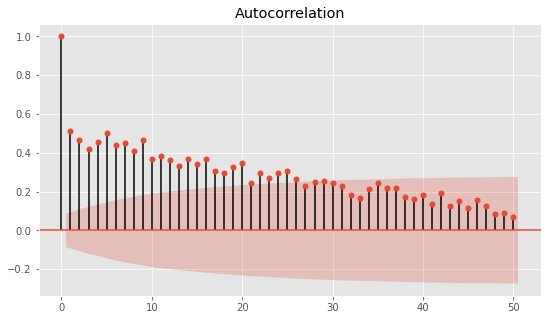

In [56]:
import statsmodels.tsa.api as smt
# Confidence intervals are drawn as a cone. 
# By default, this is set to a 95% confidence interval, 
# suggesting that correlation values outside of this code are very likely a correlation 
# and not a statistical fluke
acf = smt.graphics.plot_acf(lin_reg.resid, lags=50 , alpha=0.05)
acf.show()

> - By observing the above data we can say that there is positive autocorrelation is present , we can reduce it by using fine tuning our parameters
- We can even use Generalize Least Squares (GLS) model

---

## 5. Multicollinearity 

Multicollineariy arises when one independent variable can be linearly predicted by others with a substantial level of accuracy.


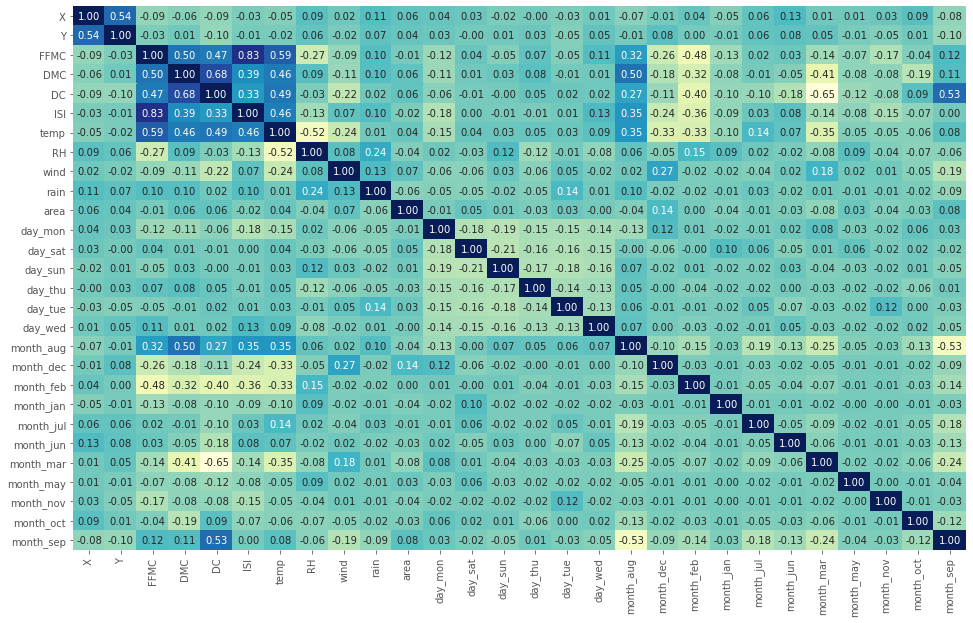

In [57]:
plt.figure(figsize =(16,10))

sns.heatmap(df.corr(),annot=True,cmap='YlGnBu',fmt=".2f",cbar=False)
plt.show()

In [58]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X.columns).sort_values(by="vif",ascending=False)

,vif
month_sep,53.307716
month_aug,43.939403
DC,26.792896
month_jul,8.378570
month_oct,7.681340
month_mar,6.694845
FFMC,5.629386
temp,4.535721
ISI,4.107793
DMC,3.978913


> There is multicollinearity present between some features where vif >5.
- We can even use PCA to reduce features to a smaller set of uncorrelated components.
- To deal with multicollinearity we should iteratively remove features with high values of VIF.


---

# Machine learning approach

In [59]:
lr = LinearRegression()
lr.fit(X, y)

print(f'Intercept: {lr.intercept_}')
print(f'R^2 score: {lr.score(X, y)}')
pd.DataFrame({"Coefficients": lr.coef_}, index=X.columns)

Intercept: 0.3192068355158263
R^2 score: 0.07698615338292181


,Coefficients
X,0.053161
Y,-0.011457
FFMC,-0.106058
DMC,0.004149
DC,-0.001854
ISI,-0.103922
temp,0.044297
RH,0.004063
wind,0.067775
rain,-0.927225


---

# Improving Stats model

**Dropping columns to improve accuracy:**
    
By checking high Variance inflation factor and p-value we will decide whether to keep the column or drop it.

> R^2 = 1 - SSE(Sum of Square of Residuals)/SST (Sum of square Total)

Just by dropping constant we got a huge bump in adjusted R2 from `2.5%` to `40.6%`.

In [60]:
X = df.drop(columns=['area','damage_category'])
y = df['area']

In [61]:
def check_stats(X,y):
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(pd.DataFrame({'vif': vif}, index=X.columns).sort_values(by="vif",ascending=False)[:10])
    lin_reg = sm.OLS(y,X).fit()
    print(lin_reg.summary())
check_stats(X,y)

                  vif
FFMC       202.334784
DC         159.585267
month_sep   77.976513
month_aug   67.081874
temp        53.012135
ISI         52.449380
RH          23.764931
Y           19.961996
DMC         15.417494
month_jul    8.764939
                                 OLS Regression Results                                
Dep. Variable:                   area   R-squared (uncentered):                   0.438
Model:                            OLS   Adj. R-squared (uncentered):              0.406
Method:                 Least Squares   F-statistic:                              13.92
Date:                Fri, 31 Jul 2020   Prob (F-statistic):                    7.32e-45
Time:                        17:45:46   Log-Likelihood:                         -874.85
No. Observations:                 510   AIC:                                      1804.
Df Residuals:                     483   BIC:                                      1918.
Df Model:                          27                 

In [62]:
X.drop(columns=['FFMC'],inplace=True)
# check_stats(X,y)

In [63]:
X.drop(columns=['Y'],inplace=True)
# check_stats(X,y)

In [64]:
X.drop(columns=['month_jul'],inplace=True)
# check_stats(X,y)

In [65]:
X.drop(columns=['day_thu'],inplace=True)
# check_stats(X,y)

In [66]:
X.drop(columns=['day_mon'],inplace=True)
# check_stats(X,y)

In [67]:
X.drop(columns=['month_aug'],inplace=True)
check_stats(X,y)

                 vif
DC         57.707223
ISI        38.292380
temp       27.680452
DMC        13.223716
RH         12.130774
wind        7.359276
X           5.267220
month_sep   3.915822
month_mar   2.741742
month_feb   1.631273
                                 OLS Regression Results                                
Dep. Variable:                   area   R-squared (uncentered):                   0.437
Model:                            OLS   Adj. R-squared (uncentered):              0.413
Method:                 Least Squares   F-statistic:                              18.07
Date:                Fri, 31 Jul 2020   Prob (F-statistic):                    2.20e-48
Time:                        17:45:49   Log-Likelihood:                         -875.21
No. Observations:                 510   AIC:                                      1792.
Df Residuals:                     489   BIC:                                      1881.
Df Model:                          21                            

Similarly, you can continue to optimize the model.

Our Prob (F-statistic) has improved from 0.0558 to 2.20e-48. As the value is less than 0.05, the model becomes more significant.

---

# Improving ML model

## Feature Selection techniques

The following can be used for selecting relevant features for model building

1. **Using Pearson Correlation**
2. **Wrapper method** 
    1. Forward Selection: Forward selection is an iterative method in which we start with having no feature in the model. In each iteration, we keep adding the feature which best improves our model till an addition of a new variable does not improve the performance of the model.
    1. Backward Elimination: In backward elimination, we start with all the features and removes the least significant feature at each iteration which improves the performance of the model. We repeat this until no improvement is observed on removal of features.
    1. Recursive Feature elimination: It is a greedy optimization algorithm which aims to find the best performing feature subset. It repeatedly creates models and keeps aside the best or the worst performing feature at each iteration. It constructs the next model with the left features until all the features are exhausted. It then ranks the features based on the order of their elimination.
3. **Embedded method**, lasso is one such method which penalizes features based on feature importance, making lesss important feature to 0.

In [68]:
X_m, y_m = df_ml.drop(columns=[target]), df_ml[target]

### RFE

Out of 27 features, best number of features 1


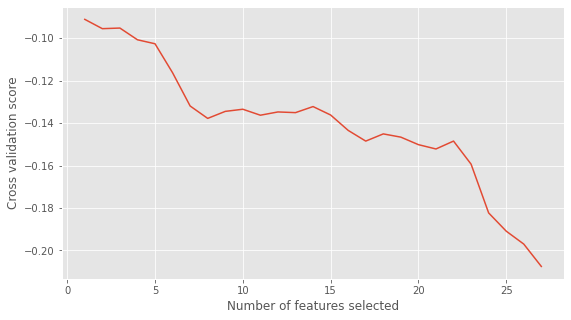

In [69]:
# RFECV is a variant with inbuilt Cross validation
model = LinearRegression()
selector = RFECV(model,cv=5)
selector = selector.fit(X_m, y_m)
print(f"Out of {len(X_m.columns)} features, best number of features {selector.n_features_}")
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(X_m.columns) + 1), selector.grid_scores_)
plt.show()

Out of 27 features, best number of features 19
['X' 'wind' 'rain' 'day_mon' 'day_sat' 'day_sun' 'day_thu' 'day_tue'
 'day_wed' 'month_aug' 'month_dec' 'month_feb' 'month_jan' 'month_jul'
 'month_jun' 'month_mar' 'month_may' 'month_nov' 'month_oct']


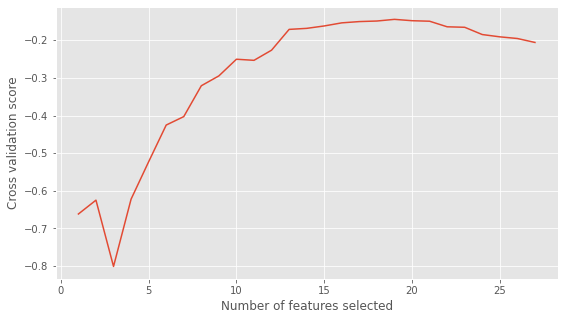

In [70]:
# In our stats method we found that the intercept was not relevant 
# Let's try that feature out in our ML model
model = LinearRegression(fit_intercept=False)
selector = RFECV(model,cv=5)
selector = selector.fit(X_m, y_m)
print(f"Out of {len(X_m.columns)} features, best number of features {selector.n_features_}")

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(X_m.columns) + 1), selector.grid_scores_)
print(X_m.columns[selector.support_].values)
plt.show()

**Building model with the best features and checking the R2 score for the same**

In [71]:
mask = selector.support_
print(f"Best features according to RFE {X_m.columns[mask].values}")

X_m1 = X_m.iloc[:,mask]
# We could have used train test split or cross validation strategies
# for scoring the model but in order to compare with the stats model 
# we will use the whole data
model1 = LinearRegression().fit(X_m1,y_m)
print(f"R2 Score: {model1.score(X_m1,y_m)}")

Best features according to RFE ['X' 'wind' 'rain' 'day_mon' 'day_sat' 'day_sun' 'day_thu' 'day_tue'
 'day_wed' 'month_aug' 'month_dec' 'month_feb' 'month_jan' 'month_jul'
 'month_jun' 'month_mar' 'month_may' 'month_nov' 'month_oct']
R2 Score: 0.05542824436801641


### Forward Selection

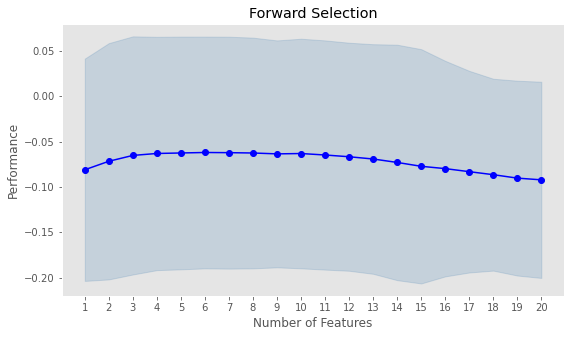

In [72]:
model = LinearRegression(fit_intercept=False)
sfs1 = sfs(model,k_features=20,forward=True,scoring='r2',cv=5)
sfs1.fit(X_m,y_m)
fig = plot_sfs(sfs1.get_metric_dict())
plt.title('Forward Selection')
plt.grid()
plt.show()

In [73]:
print(sfs1.k_features, sfs1.k_feature_names_,sep="\n")

20
('X', 'FFMC', 'ISI', 'RH', 'wind', 'rain', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_mar', 'month_nov', 'month_oct')


In [74]:
index = list(sfs1.k_feature_idx_)
X_m1 = X_m.iloc[:,index]
model1 = LinearRegression().fit(X_m1,y_m)
print(f"R2 Score: {model1.score(X_m1,y_m)}")

R2 Score: 0.054721988510710196


### Backward Selection

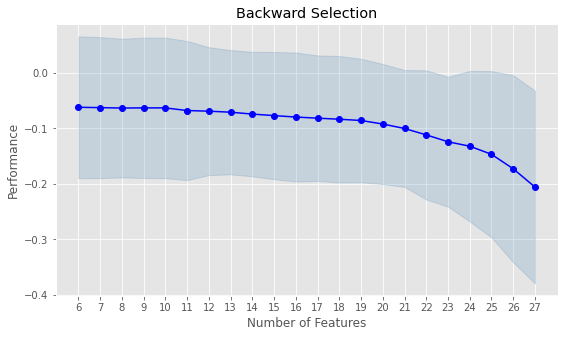

In [75]:
model = LinearRegression(fit_intercept=False)
sfs1 = sfs(model,k_features=6,forward=False,scoring='r2',cv=5)
sfs1.fit(X_m,y_m)
fig = plot_sfs(sfs1.get_metric_dict())
plt.title('Backward Selection')
plt.grid(True)
plt.show()

In [76]:
index = list(sfs1.k_feature_idx_)
print(f"Best features according to RFE: {X_m.columns[index]}")

X_m1 = X_m.iloc[:,index]
model1 = LinearRegression().fit(X_m1,y_m)
print(f"R2 Score: {model1.score(X_m1,y_m)}")

Best features according to RFE: Index(['X', 'FFMC', 'rain', 'month_jan', 'month_mar', 'month_nov'], dtype='object')
R2 Score: 0.018212646031610876


## Regularization
1. Lasso
2. Ridge
3. ElasticNet


### Ridge

In [77]:
# higher the alpha value, more restriction on the coefficients; 
# lower the alpha > more generalization, coefficients are barely
rr = RidgeCV(cv=5,fit_intercept=False) 
rr.fit(X_m, y_m)
rr.score(X_m,y_m)

0.06055519668815201

In [78]:
rr.alpha_

10.0

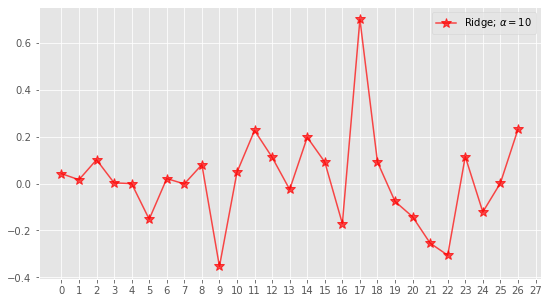

In [79]:
plt.plot(rr.coef_,alpha=0.7,marker='*',markersize=10,color='red',label=r'Ridge; $\alpha =10$') 
plt.grid(True)
plt.xticks(range(0,28,1))
plt.legend()
plt.show()